Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image

Torch Version

In [3]:
print(torch.__version__)

2.2.2


GPU Check

In [7]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [8]:
torch.set_num_threads(1) # to minimize the cpu utilization

VGG16

In [10]:
vgg16 = models.vgg16(pretrained=False)
num_classes = 2 
vgg16.classifier[6] = torch.nn.Linear(vgg16.classifier[6].in_features, num_classes)

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
train_set = datasets.ImageFolder(root='real-vs-fake/train', transform=transform)
test_set = datasets.ImageFolder(root='real-vs-fake/test', transform=transform)
val_set = datasets.ImageFolder(root='real-vs-fake/valid', transform=transform)


train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)


num_train_images = len(train_loader.dataset)
num_test_images = len(test_loader.dataset)
num_val_images = len(val_loader.dataset)


print("Number of training images:", num_train_images)
print("Number of testing images:", num_test_images)
print("Number of validating images:", num_val_images)


train_classes = train_loader.dataset.classes
print("Classes in the dataset:", train_classes)

Number of training images: 159957
Number of testing images: 75992
Number of validating images: 25998
Classes in the dataset: ['fake', 'real']


In [12]:
model = vgg16.to(mps_device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    vgg16.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(mps_device), labels.to(mps_device)

        optimizer.zero_grad() 
        outputs = vgg16(images) 
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = 100.0 * train_correct / total_train
    
    vgg16.eval() 
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    
    with torch.no_grad(): 
        for images, labels in val_loader:
            images, labels = images.to(mps_device), labels.to(mps_device)

            outputs = vgg16(images)  
            loss = criterion(outputs, labels) 
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_accuracy = 100.0 * val_correct / total_val

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / total_train:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss / total_val:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(vgg16.state_dict(), "best_vgg16.pth")


Epoch 1/10, Train Loss: 0.3932, Train Accuracy: 79.95%, Validation Loss: 0.3775, Validation Accuracy: 81.71%  
Epoch 2/10, Train Loss: 0.2966, Train Accuracy: 84.23%, Validation Loss: 0.2847, Validation Accuracy: 87.49%  
Epoch 3/10, Train Loss: 0.2355, Train Accuracy: 88.06%, Validation Loss: 0.2566, Validation Accuracy: 89.90%  
Epoch 4/10, Train Loss: 0.2287, Train Accuracy: 90.66%, Validation Loss: 0.2304, Validation Accuracy: 91.00%  
Epoch 5/10, Train Loss: 0.1986, Train Accuracy: 91.93%, Validation Loss: 0.2100, Validation Accuracy: 92.50%  
Epoch 6/10, Train Loss: 0.2091, Train Accuracy: 92.55%, Validation Loss: 0.2201, Validation Accuracy: 93.77%  
Epoch 7/10, Train Loss: 0.1801, Train Accuracy: 93.71%, Validation Loss: 0.1971, Validation Accuracy: 94.01%  
Epoch 8/10, Train Loss: 0.2017, Train Accuracy: 94.09%, Validation Loss: 0.1547, Validation Accuracy: 95.11%  
Epoch 9/10, Train Loss: 0.1435, Train Accuracy: 95.19%, Validation Loss: 0.1415, Validation Accuracy: 95.88%  
E

In [13]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(mps_device), labels.to(mps_device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {(100 * correct / total):.2f}%")


Accuracy on test set: 96%


Cropping

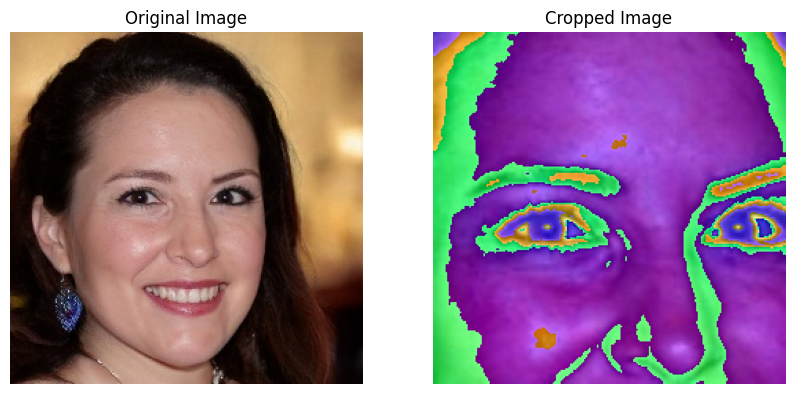

In [4]:
def crop_image(x, y, width, height):
    return transforms.Lambda(lambda img: img.crop((x, y, x + width, y + height)))

x, y = 50, 50
crop_width, crop_height = 100, 100

transform_crop = transforms.Compose([
    transforms.Resize((224, 224)),
    crop_image(x, y, crop_width, crop_height),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.2), (0.5, 0.5, 0.5))
])
image_path = "real-vs-fake/test/fake/0DBLO08SZW.jpg"
image = Image.open(image_path)
cropped_image_tensor = transform_crop(image)
cropped_image = transforms.ToPILImage()(cropped_image_tensor)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(cropped_image)
ax[1].set_title("Cropped Image")
ax[1].axis("off")

plt.show()

In [5]:
train_set_crop = datasets.ImageFolder(root='real-vs-fake/train', transform=transform_crop)
test_set_crop = datasets.ImageFolder(root='real-vs-fake/test', transform=transform_crop)
val_set_crop = datasets.ImageFolder(root='real-vs-fake/valid', transform=transform_crop)


train_loader_crop = DataLoader(train_set_crop, batch_size=32, shuffle=True)
test_loader_crop = DataLoader(test_set_crop, batch_size=32, shuffle=False)
val_loader_crop = DataLoader(val_set_crop, batch_size=32, shuffle=False)


num_train_images = len(train_loader_crop.dataset)
num_test_images = len(test_loader_crop.dataset)
num_val_images = len(val_loader_crop.dataset)


print("Number of training images:", num_train_images)
print("Number of testing images:", num_test_images)
print("Number of validating images:", num_val_images)


train_classes = train_loader_crop.dataset.classes
print("Classes in the dataset:", train_classes)

Number of training images: 159957
Number of testing images: 75992
Number of validating images: 25998
Classes in the dataset: ['fake', 'real']


Traing with crop

In [13]:
model = vgg16.to(mps_device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    vgg16.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for images, labels in train_loader_crop:
        images, labels = images.to(mps_device), labels.to(mps_device)

        optimizer.zero_grad() 
        outputs = vgg16(images) 
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = 100.0 * train_correct / total_train
    
    vgg16.eval() 
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    
    with torch.no_grad(): 
        for images, labels in val_loader_crop:
            images, labels = images.to(mps_device), labels.to(mps_device)

            outputs = vgg16(images)  
            loss = criterion(outputs, labels) 
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_accuracy = 100.0 * val_correct / total_val

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / total_train:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss / total_val:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(vgg16.state_dict(), "best_vgg16_crop.pth")


Epoch 1/10, Train Loss: 0.3932, Train Accuracy: 79.95%, Validation Loss: 0.3775, Validation Accuracy: 81.71%
Epoch 2/10, Train Loss: 0.2966, Train Accuracy: 84.23%, Validation Loss: 0.2847, Validation Accuracy: 87.49%
Epoch 3/10, Train Loss: 0.2355, Train Accuracy: 88.06%, Validation Loss: 0.2566, Validation Accuracy: 89.90%
Epoch 4/10, Train Loss: 0.2287, Train Accuracy: 90.66%, Validation Loss: 0.2304, Validation Accuracy: 91.00%
Epoch 5/10, Train Loss: 0.1986, Train Accuracy: 91.93%, Validation Loss: 0.2100, Validation Accuracy: 92.50%
Epoch 6/10, Train Loss: 0.2091, Train Accuracy: 92.55%, Validation Loss: 0.2201, Validation Accuracy: 93.77%
Epoch 7/10, Train Loss: 0.1801, Train Accuracy: 93.71%, Validation Loss: 0.1971, Validation Accuracy: 94.01%
Epoch 8/10, Train Loss: 0.2017, Train Accuracy: 94.09%, Validation Loss: 0.1547, Validation Accuracy: 95.92%
Epoch 9/10, Train Loss: 0.1435, Train Accuracy: 95.19%, Validation Loss: 0.1422, Validation Accuracy: 95.33%
Epoch 10/10, Train 

Testing Crop

In [14]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader_crop:
        images, labels = images.to(mps_device), labels.to(mps_device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {(100 * correct / total):.2f}%")

Accuracy on test set: 95.07%
